In [2]:
%matplotlib inline
%load_ext autoreload

In [3]:
import os
os.chdir('/home/jaentrouble/adipose_train3')
print(os.getcwd())

/home/jaentrouble/adipose_train3


In [4]:
import imageio as io
import json

img_names = os.listdir('data/done')
img = []
img_name_dict = {}
for idx, name in enumerate(img_names):
    img.append(io.imread('data/done/'+name))
    img_name_dict[name] = idx

json_names = os.listdir('data/save')
data = []
for name in json_names:
    with open('data/save/'+name,'r') as j:
        data.extend(json.load(j))
for datum in data :
    datum['image'] = img_name_dict[datum['image']]

In [5]:
data_train = data[:2600]
data_val = data[2600:2900]
data_test = data[2900:]

In [37]:
!git pull
%autoreload

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 1.12 KiB | 572.00 KiB/s, done.
From https://github.com/jaentrouble/Adipose_tf_train3
   106752e..a15cd53  master     -> origin/master
Updating 106752e..a15cd53
Fast-forward
 model_trainer.py  |  2 +-
 view_result.ipynb | 21 +++++++++++++++++----
 2 files changed, 18 insertions(+), 5 deletions(-)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from model_trainer import get_model
from box_models import *
from encoder_models import *
from functools import partial

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus :
    try :
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [8]:
img_size=(400,320)
encoder_f = hr_5_3_0_gap
box_f = partial(dense_128_4_normoutpos, image_size=img_size)
savedfile_name = 'hr_5_3_0_d128_normoutpos'
target_epoch = 100

In [9]:
test_model = get_model(encoder_f, box_f, img_size)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [10]:
from pathlib import Path
savedfile_name = Path(savedfile_name)
weight_path = 'savedmodels' / savedfile_name / str(target_epoch)
test_model.load_weights(str(weight_path))

In [38]:
from model_trainer import create_val_data

X_test, Y_test = create_val_data(img, data_test, img_size)

In [39]:
test_model.evaluate(X_test,Y_test, batch_size=10)

30/30 [==============================] - 3s 115ms/step - loss: 0.0010


0.0010042577050626278

In [40]:
Target_X = {}
Target_X['image'] = X_test['image'][:10]
Target_X['pos'] = X_test['pos'][:10]
Target_Y = Y_test[:10]
Target_data = data_test[:10]
predict = test_model(Target_X)
predict = predict.numpy()

In [41]:
predict = np.clip(predict, 0, 1)
print(predict[5])

[0.7475586  0.36743164 0.88623047 0.5239258 ]


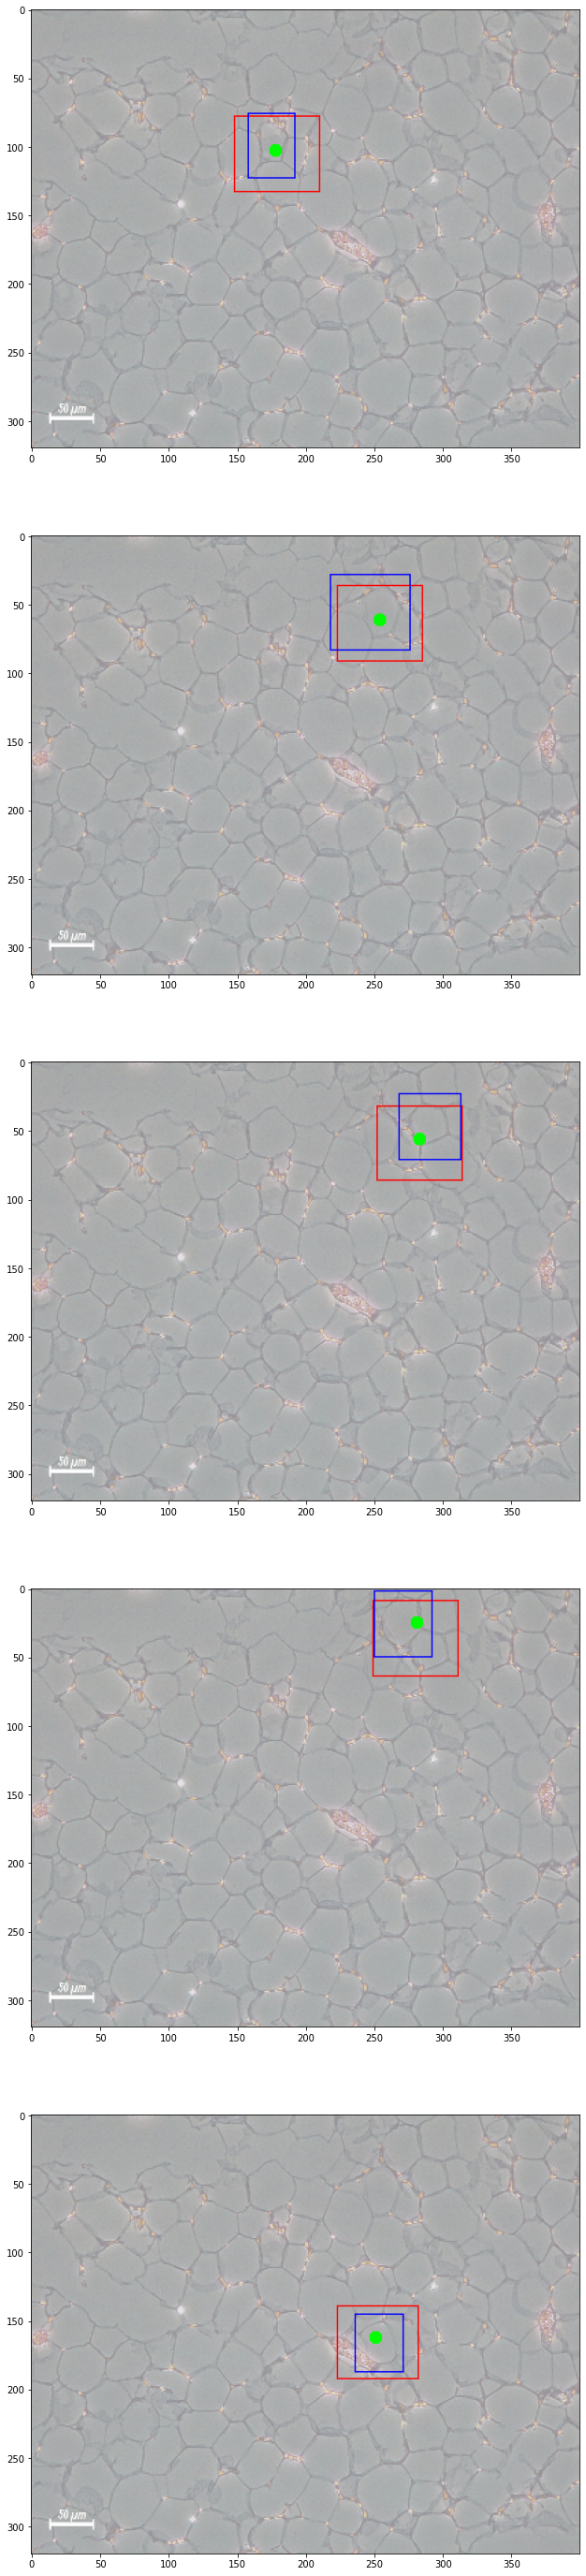

In [48]:
from skimage import draw
fig = plt.figure(figsize=(50,50))
for idx in range(5):
    ax = fig.add_subplot(5,1,idx+1)
    img = Target_X['image'][idx].copy().swapaxes(0,1)
    pos = Target_X['pos'][idx]
    height, width = img.shape[:2]
    xmin,ymin,xmax,ymax = predict[idx] * [width, height, width, height]
    rr, cc = draw.disk((pos[1],pos[0]),5, shape=img.shape[:2])
    img[rr,cc] = [0,255,0]
    rr, cc = draw.rectangle_perimeter((ymin,xmin),(ymax,xmax),shape=img.shape[:2])
    img[rr,cc] = [255,0,0]

    xmin,ymin,xmax,ymax = Target_Y[idx] * [width, height, width, height]
    rr, cc = draw.rectangle_perimeter((ymin,xmin),(ymax,xmax),shape=img.shape[:2])
    img[rr,cc] = [0,0,255]
    ax.imshow(img)
plt.show()